<a href="https://colab.research.google.com/github/Benjamin025/Benjamin025/blob/main/Watershed%20Delineation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##the aim of the notebook is to generate a watershed from a dem within my area of interest in this case Nakuru county in Kenya.

In [ ]:
##the first step is to import the necessary libraries for the delianation of a watershed from a DEM(SRTM30m)
##importing the os module
##the ipython module for display will also be of essence

In [ ]:
import os
import IPython.display as display

In [ ]:
##importing of additional modules such as dgal from osgeo

In [ ]:
from osgeo import gdal

In [ ]:
##additional modules for the processing are also imported from various packages

In [ ]:
import subprocess
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
%matplotlib inline






[C 12:15:27.153 NotebookApp] No such file or directory: /content/restart


In [ ]:
##a line to import gdal using pip if the previous impotation fails or results to null importation of the package gdal
##after importing with pip one need to restart the notebook for the purposes of ensuring the package gdal in succefully imported and ready for processing

In [ ]:
!pip install gdal
!jupyter notebook restart

[C 13:00:25.076 NotebookApp] No such file or directory: /content/restart


In [ ]:
##installing of the rasterio package facilitates in the writing and reading of geospatial datasets

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 30.9 MB/s eta 0:00:00


In [ ]:
##import additonal packages in rasterio geometry window,merge and show for display of the ploted dataset with rasterio

In [ ]:
import rasterio
from rasterio.features import geometry_window
from rasterio.merge import merge
from rasterio.plot import show


In [ ]:
##a code snippet to upload the datasets to be utilized in this case a dem for Nakuru county for my processing
##the aim of the is to generate a watershed from a dem


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving nakuru_srtm1.tif to nakuru_srtm1.tif
User uploaded file "nakuru_srtm1.tif" with length 44588425 bytes


In [ ]:
!pip install pysheds

In [ ]:
##the first step is to read the uploaded dem data from the drive by utizing pysheds
##assign variables for the grid and dem to be used to the path direction of the uploaded dataset

In [ ]:

from pysheds.grid import Grid

grid = Grid.from_raster('/content/nakuru_srtm1.tif')
dem = grid.read_raster('/content/nakuru_srtm1.tif')

In [ ]:
##after reading the dataset the next step is to plot the dataset
##additional packages will be required for the plotting part
##numpy
##plot utilizing matplot lib
##seaborn package for statistical data visualizatiion a python library

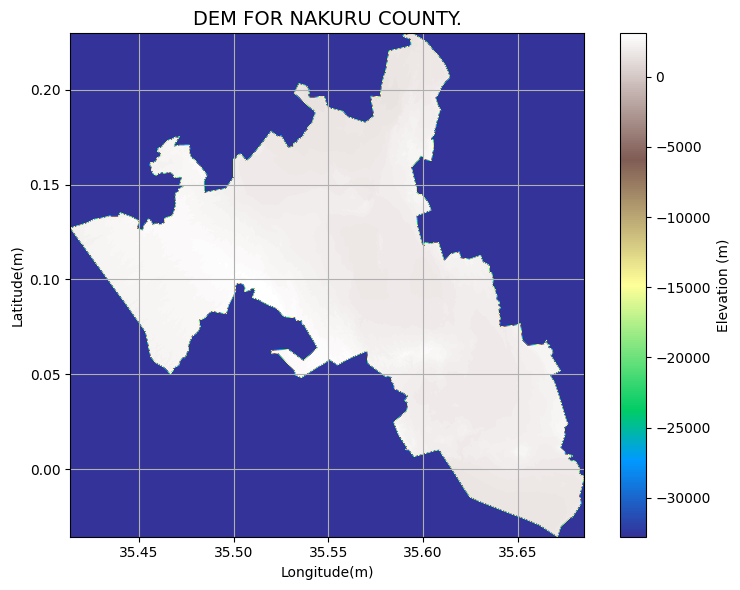

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('DEM FOR NAKURU COUNTY.', size=14)
plt.xlabel('Longitude(m)')
plt.ylabel('Latitude(m)')
plt.tight_layout()

In [ ]:
##Condition DEM for preparing the dem
##if the are any pit present in the dem fill the
##also fill the depressions within the dem
##next is to resolve flats in the dem

In [ ]:
pit_filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(pit_filled_dem)
inflated_dem = grid.resolve_flats(flooded_dem)

In [ ]:
##next is to determine the flow directions within each of the cell using a D8 flow method
##the D8 flow method determines the flow direction of each pixel to it's steepest downslope neighbour
##also specify the directional mapping using the coded vaues of the direction of flow(64,128,1,2,4,8,16,32)
##after which you will compute the flow directions

In [ ]:

dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

In [ ]:
##after which to plot the flow direction grid computed above

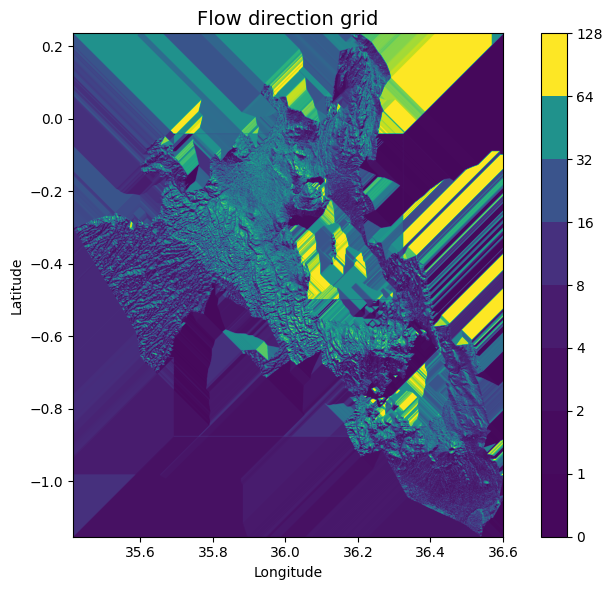

In [ ]:
ig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [ ]:
##Next is to calculate the flow accumulation based on the flow grid obtained
##this flow accumulation is calculated based on the accumulated weights of the cells flowing into each of the downward cells

In [ ]:
acc = grid.accumulation(fdir, dirmap=dirmap)

In [ ]:
##Next is to plot the obatined flow accumulation from the previous step
##the interpolation to be utilized in this case is bilinear interpolation

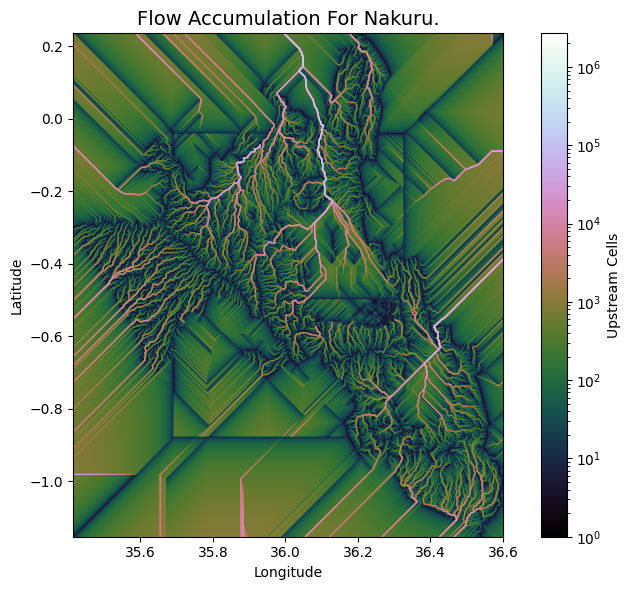

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation For Nakuru.', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [ ]:
## Delineate a catchment
## Specify pour point

In [ ]:
##the will be need to specify the pour point in terms of x,y
x, y = 35.6, -0.4

##Snap pour point to high accumulation cell based on the pixels
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                       xytype='coordinate')

# Clip the bounding box to the catchment provided above
grid.clip_to(catch)
clipped_catch = grid.view(catch)

In [ ]:
##Next is to Plot the catchment from the above

Text(0.5, 1.0, 'Delineated Catchment')

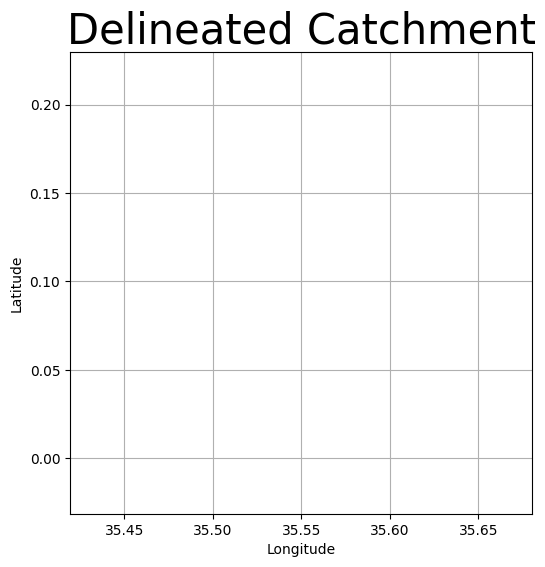

In [ ]:

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=30)

In [ ]:
# Extract river network from the delianeted catchment
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

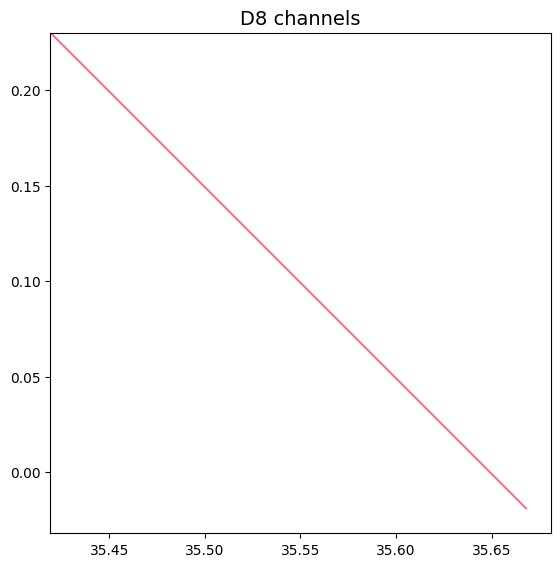

In [ ]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

_ = plt.title('D8 channels', size=14)

In [ ]:
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

Text(0.5, 1.0, 'Flow Distance')

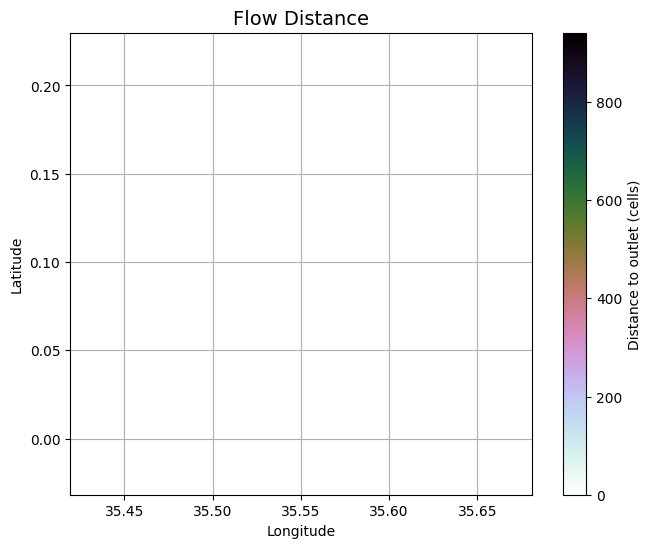

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)